
# Introduction

This study delves into the fascinating realm of astronomical data analysis, focusing on the classification of exoplanets based on their characteristics. Given the complexity and variety within the datasets, machine learning offers a compelling approach to unravel patterns and relationships that may not be immediately apparent.

### Aim
This project aims to determine the most effective machine learning model for accurately classifying exoplanets. Leveraging the defining features of these distant worlds, the study seeks to predict their classifications, which span a range from Gas Giants to Terrestrial types.

### Machine Learning Models
The first phase involves implementing the k-Nearest Neighbors (kNN) algorithm to evaluate its classification performance on exoplanetary data. Subsequently, a Decision Tree classifier will be developed from scratch. The performances of both models will be compared to ascertain which algorithm is more adept at capturing the intricate details necessary for precise exoplanet classification, with particular attention to accuracy and generalizability.

### Dataset used in the analyssis

The dataset used in this project is sourced from the NASA Exoplanet Archive, a comprehensive database of exoplanets discovered by NASA missions and various observatories. It contains detailed records of exoplanets' names, masses, radii, and orbital characteristics, alongside data on their stellar hosts. This valuable CSV file, downloaded from [Kaggle](https://www.kaggle.com/datasets/adityamishraml/nasaexoplanets?resource=download), offers a rich set of variables that are instrumental for the classification and analysis of exoplanets, aiding in the exploration of celestial bodies beyond our solar system.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [2]:
# Load the dataset
data = pd.read_csv("kaggle-exoplanets-dataset.csv")

## Data Cleaning Decisions: A Balancing Act

Our initial dataset for this exoplanet analysis contained missing information in several key columns. While missing data is a common challenge in scientific exploration, I considered the most effective approach for our purposes. I opted to remove rows with missing entries for the following reasons:

Minimizing bias: Leaving missing values untreated can introduce bias into our analysis, potentially skewing our results and conclusions. Removing rows with missing information eliminates this risk, ensuring the integrity of our findings.

Focus on complete data: Our analysis relies on understanding the relationships between various exoplanet characteristics. Missing values in any of these features would hinder the model's ability to accurately conclude. By focusing on complete data points, we gain a clearer picture of these relationships.

In [3]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 name                   0
distance              17
stellar_magnitude    161
planet_type            0
discovery_year         0
mass_multiplier       23
mass_wrt              23
radius_multiplier     17
radius_wrt            17
orbital_radius       289
orbital_period         0
eccentricity           0
detection_method       0
dtype: int64


In [4]:
data = data.dropna()

In [5]:
missing_columns = ["distance", "stellar_magnitude", "mass_multiplier", "mass_wrt", "orbital_radius","radius_wrt","radius_multiplier"]
data = data.dropna(subset=missing_columns)

In [6]:
missing_values = data.isnull().sum()
print("Missing values in each column after dropping:\n", missing_values)

Missing values in each column after dropping:
 name                 0
distance             0
stellar_magnitude    0
planet_type          0
discovery_year       0
mass_multiplier      0
mass_wrt             0
radius_multiplier    0
radius_wrt           0
orbital_radius       0
orbital_period       0
eccentricity         0
detection_method     0
dtype: int64


Assert to check if missing values are still present

In [7]:
assert data.isnull().sum().sum() == 0, "Missing values still present!"

### Remove unknown planet types

In the dataset from the NASA Exoplanet Archive, rows with 'unknown' planet types were removed to ensure the integrity and reliability of the machine learning models. These entries lack definitive classification, which could introduce ambiguity and potentially skew the model's learning process. By focusing on well-defined classes, the models are trained on clear, categorical outcomes, resulting in more accurate and generalizable predictions for exoplanet classification. This deliberate data curation step is crucial for maintaining a high standard of data quality in predictive modeling.

In [8]:
data = data[data['planet_type'] != 'unknown']

### Replace Earth measurements with Jupiter measurements

The initial dataset included exoplanet measurements in both Earth and Jupiter units, presenting a duality of scales that could lead to inconsistencies in analysis. To streamline the dataset and ensure uniformity in comparisons and calculations, we converted all planetary mass and radius measurements to Jupiter units, the common astronomical standard for giant exoplanets. This standardization simplifies the dataset, allowing for more accurate modeling and interpretation of the physical characteristics of these distant worlds.

In [9]:
# Convert mass and radius to Jupiter units
earth_to_jupiter_mass = 1 / 317.83
earth_to_jupiter_radius = 1 / 11.209

# Replace Earth measurements with Jupiter measurements
data.loc[data['mass_wrt'] == 'Earth', 'mass_multiplier'] *= earth_to_jupiter_mass
data.loc[data['radius_wrt'] == 'Earth', 'radius_multiplier'] *= earth_to_jupiter_radius

# Now we can drop the 'mass_wrt' and 'radius_wrt' columns as they are all in Jupiter units and hence not required anymore
data.drop(['mass_wrt', 'radius_wrt'], axis=1, inplace=True)


### logarithmic transformation

Applying a logarithmic transformation to the 'orbital_radius' to reduce skewness. This transformation can help to stabilize the variance across the range of data, bring the data closer to a normal distribution, and make it easier for machine learning models to learn from the data. Since many models assume or perform better with normally distributed data, this preprocessing step can improve model accuracy and the ability to generalize.

In [10]:
from scipy.stats import skew

# Calculate skewness before log transformation
original_orbital_radius_skew = skew(data['orbital_radius'])
original_orbital_period_skew = skew(data['orbital_period'])

# Apply log transformation to 'orbital_radius' and 'orbital_period' to reduce skewness
data['orbital_radius_log'] = np.log1p(data['orbital_radius'])
data['orbital_period_log'] = np.log1p(data['orbital_period'])

# Calculate skewness after log transformation
log_orbital_radius_skew = skew(data['orbital_radius_log'])
log_orbital_period_skew = skew(data['orbital_period_log'])

# Output the skewness values
print(f"Original Orbital Radius Skew: {original_orbital_radius_skew}")
print(f"Log-transformed Orbital Radius Skew: {log_orbital_radius_skew}")
print(f"Original Orbital Period Skew: {original_orbital_period_skew}")
print(f"Log-transformed Orbital Period Skew: {log_orbital_period_skew}")

# Drop the original 'orbital_radius' and 'orbital_period' columns
data.drop(['orbital_radius', 'orbital_period'], axis=1, inplace=True)


Original Orbital Radius Skew: 39.256076480642285
Log-transformed Orbital Radius Skew: 5.555190030696066
Original Orbital Period Skew: 54.675170453107235
Log-transformed Orbital Period Skew: 6.241847666769752


The logarithmic transformation significantly reduced the skewness in both the 'orbital_radius' and 'orbital_period' data. Initially, 'orbital_radius' had a very high skewness value of 39.26, indicating a severe rightward skew. After transformation, it decreased to 5.56, showing a substantial normalization of the distribution. Similarly, 'orbital_period' was extremely skewed with a value of 54.68, which was reduced to 6.24. Although still positively skewed, the log transformation has effectively moderated extreme values, making the data more symmetrical and suitable for machine learning models that assume normality.

### Convert categorical data to numerical format using Label Encoding

In [11]:
# Label encoding for categorical columns
label_encoders = {}
for column in ['planet_type','detection_method']:
    encoder = LabelEncoder()
    data[column] = encoder.fit_transform(data[column])
    label_encoders[column] = encoder

### Split data into features and target

In [12]:
# Split data into features and target
X = data.drop(['planet_type', 'name'], axis=1) # Dropping 'name' as it's not useful for modeling
Y = data['planet_type']

### Split the data into training and test sets

In [13]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [14]:
# Output the shapes of the resulting data splits to verify
print("Training set shape:", X_train.shape, Y_train.shape)
print("Testing set shape:", X_test.shape, Y_test.shape)

Training set shape: (3812, 9) (3812,)
Testing set shape: (953, 9) (953,)


### Feature Scaling


In this section, we are refining our data to ensure our model learns effectively. We identify and remove constant features that don't vary across samples, as they hold no informational value. Next, we address any missing values by imputing them with the mean, ensuring no data points are left blank. Finally, we scale the features to standardize the data, giving each feature equal importance and preparing it for the machine learning algorithms. The result is a dataset optimized for training and testing our models.

In [15]:
# Identifying constant features
constant_features = [col for col in X_train.columns if X_train[col].nunique() == 1]

# Dropping constant features (if any)
X_train = X_train.drop(columns=constant_features)
X_test = X_test.drop(columns=constant_features)

# Imputing missing values (if any)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [16]:
# Convert the scaled arrays back into DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)


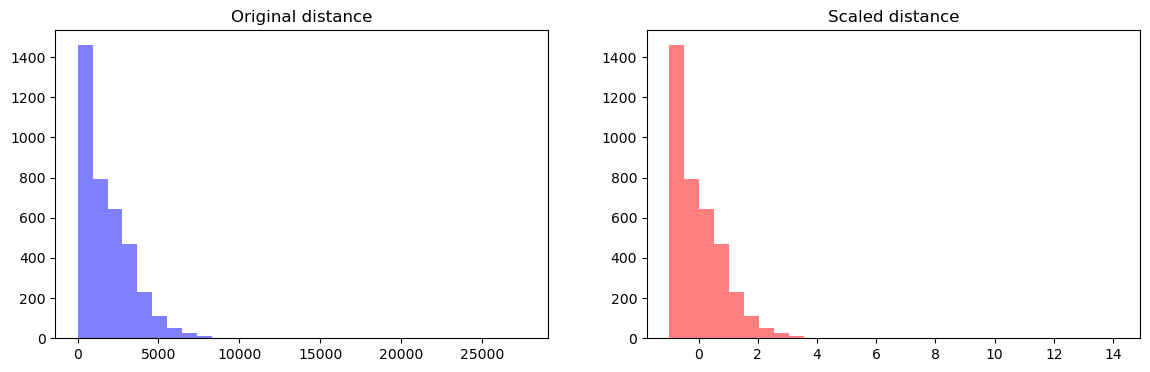

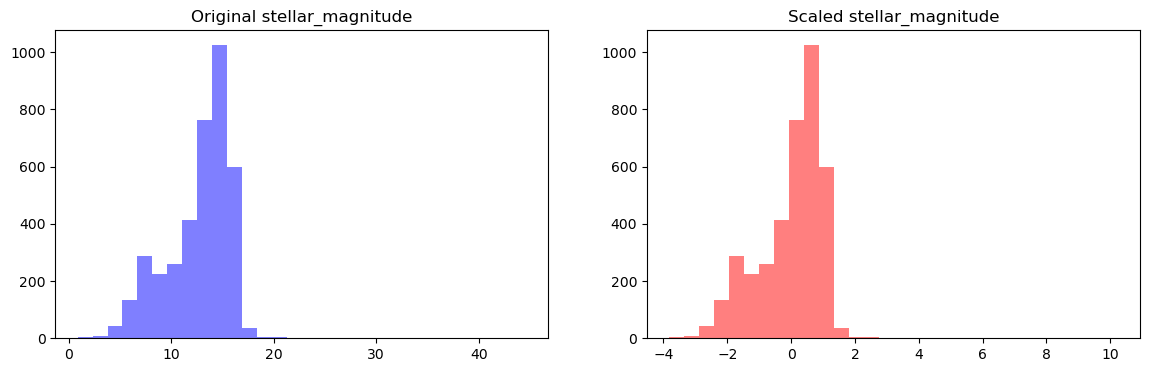

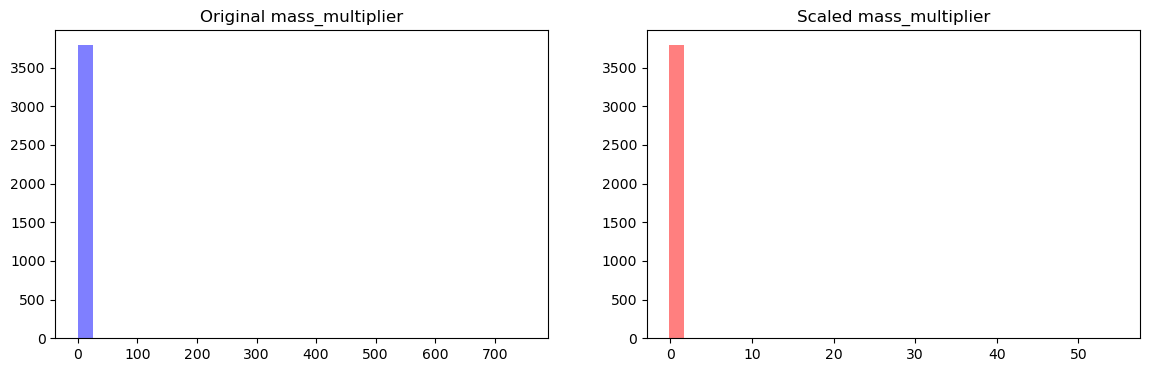

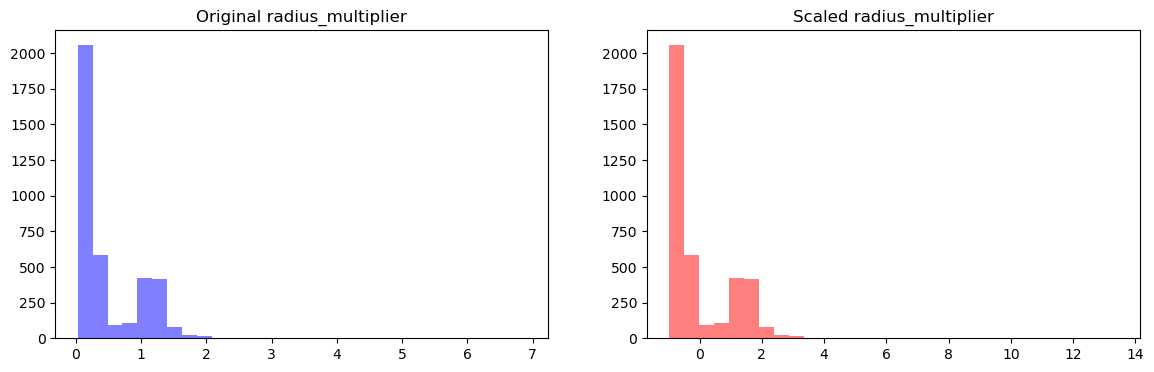

In [17]:
# Visualization function for feature distributions
def plot_feature_distribution(features):
    for feature in features:
        fig, ax = plt.subplots(1, 2, figsize=(14, 4))
        ax[0].hist(X_train[feature], bins=30, alpha=0.5, color='blue')
        ax[0].set_title(f'Original {feature}')
        ax[1].hist(X_train_scaled_df[feature], bins=30, alpha=0.5, color='red')
        ax[1].set_title(f'Scaled {feature}')
        plt.show()

# List of features you want to visualize
features_to_visualize = ['distance', 'stellar_magnitude', 'mass_multiplier', 'radius_multiplier'] # modify as needed

# Plot the distributions before and after scaling
plot_feature_distribution(features_to_visualize)

The feature scaling process has transformed the data, normalizing the distribution of values within each feature. The histograms now exhibit distributions centered around a mean of zero, with a reduced range of values, indicating that the scaling was successful. This normalization is crucial for models that are sensitive to the scale of the data, as it ensures each feature contributes equally to the model's performance.

### Handling Imbalanced Data
In this section, we will address the challenge of imbalanced classes in our dataset. Using the SMOTE algorithm, we will generate synthetic samples for underrepresented classes, aiming for an equal number of instances across all planet types. This pre-processing step is crucial for preventing model bias toward more common classes and ensuring a fair and accurate learning process. The resulting balanced dataset will allow our machine learning models to perform more effectively during training.

In [18]:
# Count the number of samples in each class
class_counts = Y_train.value_counts()
print(class_counts)

# Find the smallest class size
smallest_class_size = class_counts.min()
print("Smallest class size:", smallest_class_size)

# Setting k_neighbors for SMOTE
# Ensure k_neighbors is less than the smallest class size
sm = SMOTE(random_state=42, k_neighbors=min(2, smallest_class_size - 1))
X_train_res, Y_train_res = sm.fit_resample(X_train_scaled, Y_train)

# After resampling, you can check the class distribution again
class_counts_resampled = pd.Series(Y_train_res).value_counts()
print(class_counts_resampled)


1    1338
2    1195
0    1120
3     159
Name: planet_type, dtype: int64
Smallest class size: 159
1    1338
0    1338
2    1338
3    1338
Name: planet_type, dtype: int64


By implementing Synthetic Minority Over-sampling Technique (SMOTE), we've synthetically augmented the minority class to equalize the class distribution

### Feature Distributions After Logarithmic Transformation

In this section, we observe the transformed feature distributions. The logarithmic transformation has adjusted the scales of 'orbital_radius' and 'orbital_period', reducing the right skew and allowing patterns to be seen more clearly. The histograms display these features on a log scale, providing a visual representation of the data's new, more normalized state. This step is crucial for the subsequent machine learning models, as it ensures that the range of values within each feature won't unduly influence the models' training processes.

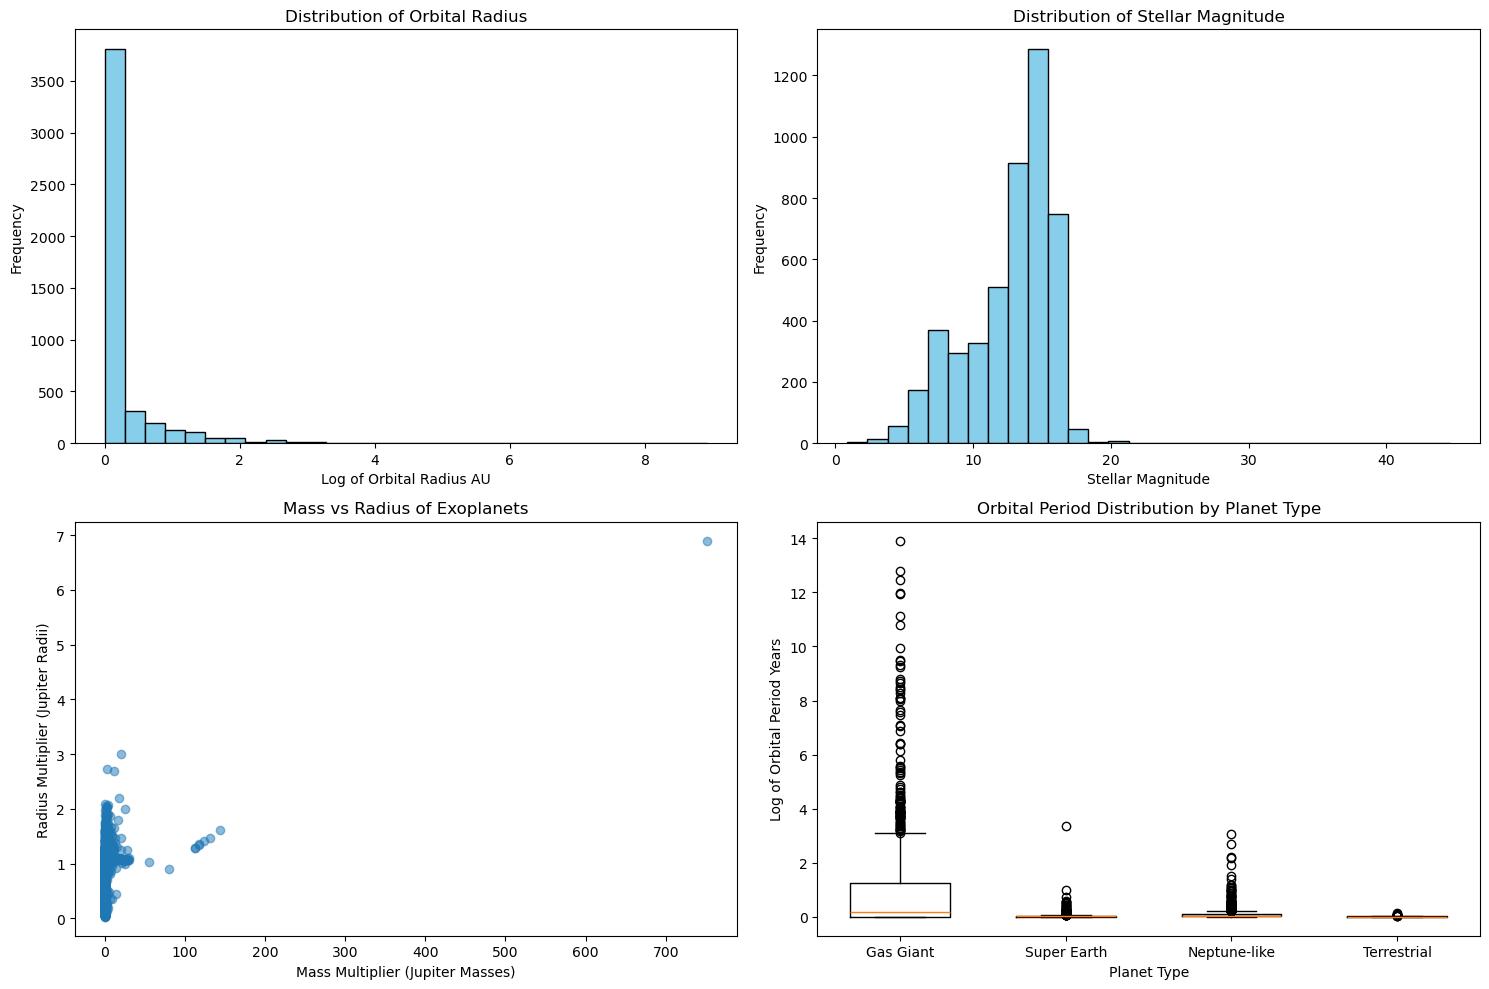

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10)) # Adjust the figure size as needed

# Distribution of Orbital Radius
axs[0, 0].hist(data['orbital_radius_log'], bins=30, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Distribution of Orbital Radius')
axs[0, 0].set_xlabel('Log of Orbital Radius AU')
axs[0, 0].set_ylabel('Frequency')

# Distribution of Stellar Magnitude
axs[0, 1].hist(data['stellar_magnitude'], bins=30, color='skyblue', edgecolor='black')
axs[0, 1].set_title('Distribution of Stellar Magnitude')
axs[0, 1].set_xlabel('Stellar Magnitude')
axs[0, 1].set_ylabel('Frequency')

# Mass vs Radius of Exoplanets
axs[1, 0].scatter(data['mass_multiplier'], data['radius_multiplier'], alpha=0.5)
axs[1, 0].set_title('Mass vs Radius of Exoplanets')
axs[1, 0].set_xlabel('Mass Multiplier (Jupiter Masses)')
axs[1, 0].set_ylabel('Radius Multiplier (Jupiter Radii)')

# Orbital Period Distribution by Planet Type
planet_types = label_encoders['planet_type'].inverse_transform(data['planet_type'].unique())
for index, planet_type in enumerate(planet_types):
    subset = data[data['planet_type'] == label_encoders['planet_type'].transform([planet_type])[0]]
    axs[1, 1].boxplot(subset['orbital_period_log'], positions=[index], widths=0.6)

axs[1, 1].set_title('Orbital Period Distribution by Planet Type')
axs[1, 1].set_xlabel('Planet Type')
axs[1, 1].set_ylabel('Log of Orbital Period Years')
axs[1, 1].set_xticklabels(planet_types)

plt.tight_layout()
plt.show()


# Machine learning models

This section introduces the machine learning models applied to classify exoplanets. We explore their performance and compare their abilities to predict planetary types based on the dataset's features.

## K-nearest neighbors using Euclidean distance

Here we examine the k-Nearest Neighbors (kNN) model, utilizing Euclidean distance to classify exoplanets. We assess its accuracy and how well it generalizes to unseen data.

### Import libraries

In [20]:
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

### Defining the class function that will be used for K-nearest neighbours

In [21]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

class kNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predicted_labels = [self._predict(x) for x in X]
        return np.array(predicted_labels)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]
        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # Return the most common class label
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

### Example usage

In [22]:
# This is the example usage using the random_state 42 for splitting and smote
# Instantiate the kNN with k neighbors
k = 3  
knn = kNN(k)

# Fit the model
knn.fit(X_train_res , Y_train_res)

# Predict the labels on the test set
predictions = knn.predict(X_test_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(Y_test, predictions)
print(f"Accuracy of custom kNN model: {accuracy:.2f}")

Accuracy of custom kNN model: 0.84


### Analyzing KNN model's performance

The function evaluate_model_performance assesses the KNN model's ability to classify exoplanets. It splits data into training and test sets, preprocesses it, applies SMOTE to balance classes, and then fits the model. The classification report outputs precision (correct positive predictions), recall (true positives detected), and f1-score (harmonic mean of precision and recall) for each class. 'Support' shows the number of true instances for each label. 'Accuracy' reflects overall correctness, while 'macro average' and 'weighted average' provide aggregated metrics, the latter considering label imbalance.

In [23]:
from sklearn.metrics import classification_report

def evaluate_model_performance(X, Y, random_state_smote, random_state_split, class_labels):
    # Split the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state_split)
    
    # Preprocessing
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)
    
    # Apply SMOTE
    sm = SMOTE(random_state=random_state_smote, k_neighbors=min(2, Y_train.value_counts().min() - 1))
    X_train_res, Y_train_res = sm.fit_resample(X_train_scaled, Y_train)
    
    # Fit the model
    knn.fit(X_train_res, Y_train_res)
    
    # Predict the labels on the test set
    predictions = knn.predict(X_test_scaled)
    
    # Generate and return the classification report
    report = classification_report(Y_test, predictions, target_names=class_labels, output_dict=False)
    return report

# Example usage
planet_types = label_encoders['planet_type'].classes_
KNN_report = evaluate_model_performance(X, Y, random_state_smote=19, random_state_split=19, class_labels=planet_types)
print(KNN_report)


              precision    recall  f1-score   support

   Gas Giant       0.94      0.96      0.95       275
Neptune-like       0.84      0.79      0.81       341
 Super Earth       0.76      0.74      0.75       293
 Terrestrial       0.44      0.64      0.52        44

    accuracy                           0.82       953
   macro avg       0.74      0.78      0.76       953
weighted avg       0.82      0.82      0.82       953



The classification report reveals several insights into the KNN model's performance. Gas Giants are classified with high precision (0.94) and recall (0.96), indicating the model's strong ability to identify this class with few false positives or negatives. Neptune-like planets also receive high scores, but with slightly less precision and recall, hinting at occasional misclassification.

For Super Earth types, the precision and recall drop further, suggesting the model sometimes confuses them with other classes. Terrestrial planets have the lowest precision and recall, indicating a notable difficulty for the model to correctly classify this class, likely due to fewer instances to learn from, as shown by the support figures.

The overall accuracy of 0.82 is robust, but the macro average (0.74 for precision and 0.78 for recall) indicates that the model's performance is not as consistent across all classes. The weighted average corrects for class imbalance by accounting for the number of instances in each class, resulting in a score of 0.82, matching the overall accuracy.

In summary, while the model shows high accuracy overall, the varying precision, recall, and F1-scores across classes demonstrate that its effectiveness is not uniform, with certain classes being more challenging to predict than others. This suggests potential areas for model refinement and the need for strategies to improve performance, especially for underrepresented classes.

## Decision tree (self implemented)

This section introduces my self-implemented Decision Tree model, exploring its classification capabilities on the exoplanet dataset without relying on pre-built libraries.

### Defining the class function for decision tree

In [24]:
class DecisionNode:
    def __init__(self, feature_index=None, threshold=None, left_branch=None, right_branch=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left_branch = left_branch
        self.right_branch = right_branch
        self.value = value

def calculate_gini(y):
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    gini = 1 - np.sum(probabilities ** 2)
    return gini

def split_dataset(X, y, feature_index, threshold):
    left_mask = X[:, feature_index] < threshold
    right_mask = ~left_mask
    return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

def find_best_split(X, y):
    best_feature_index, best_threshold, best_gini = None, None, 1
    for feature_index in range(X.shape[1]):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            _, _, y_left, y_right = split_dataset(X, y, feature_index, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue
            gini_left = calculate_gini(y_left)
            gini_right = calculate_gini(y_right)
            weighted_gini = (len(y_left) * gini_left + len(y_right) * gini_right) / len(y)
            if weighted_gini < best_gini:
                best_gini = weighted_gini
                best_feature_index = feature_index
                best_threshold = threshold
    return best_feature_index, best_threshold

def build_tree(X, y, depth=0, max_depth=None):
    num_samples, num_features = X.shape
    if num_samples <= 1 or len(np.unique(y)) == 1 or depth == max_depth:
        leaf_value = np.argmax(np.bincount(y))
        return DecisionNode(value=leaf_value)
    best_feature_index, best_threshold = find_best_split(X, y)
    X_left, X_right, y_left, y_right = split_dataset(X, y, best_feature_index, best_threshold)
    left_branch = build_tree(X_left, y_left, depth + 1, max_depth)
    right_branch = build_tree(X_right, y_right, depth + 1, max_depth)
    return DecisionNode(best_feature_index, best_threshold, left_branch, right_branch)

def predict(sample, node):
    while node.value is None:
        if sample[node.feature_index] < node.threshold:
            node = node.left_branch
        else:
            node = node.right_branch
    return node.value

def evaluate_model_performance(X, y, tree, class_labels):
    predictions = np.array([predict(x, tree) for x in X])
    report = classification_report(y, predictions, target_names=class_labels)
    return report

In [25]:
# create the decision tree object with max_depth of 3
tree = build_tree(X_train_res, Y_train_res, max_depth=3)

In [26]:
decision_tree_report = evaluate_model_performance(X_test_scaled, Y_test, tree, class_labels=planet_types)
print(decision_tree_report)

              precision    recall  f1-score   support

   Gas Giant       0.99      1.00      1.00       315
Neptune-like       0.97      0.97      0.97       332
 Super Earth       0.97      0.95      0.96       282
 Terrestrial       0.92      0.96      0.94        24

    accuracy                           0.98       953
   macro avg       0.96      0.97      0.97       953
weighted avg       0.98      0.98      0.98       953




The decision tree model's evaluation report showcases promising performance. The precision score, which calculates the correctness of positive predictions, is high for all classes, especially for Gas Giants, indicating that when the model predicts a planet is a Gas Giant, it is correct 99% of the time. The recall score measures the model's ability to find all actual positives, and with scores of 0.96 or higher for all classes, it suggests the model misses very few positive cases. The F1-score, combining precision and recall, corroborates the model's balanced accuracy across classes.

The 'support' figure refers to the number of true instances for each class, which provides context for the other scores; despite the lower number of Terrestrial planets, the model still performs well. The overall accuracy of 0.98 reflects a high level of correct predictions across all classes. The macro average treats all classes equally, averaging the scores without considering support, and the weighted average takes class imbalance into account, both displaying high values, which signifies consistent model performance irrespective of class frequency.

## Comparing both models

In our analysis, the Decision Tree model exhibited remarkable performance with precision, recall, and F1-scores all above 0.90 for each class of exoplanets. This high level of accuracy across all metrics indicates a strong fit to the data, capable of distinguishing between different types of exoplanets effectively.

In contrast, the kNN model showed a notable range in performance across classes, with precision and recall ranging from 0.44 to 0.94. While still achieving a respectable overall accuracy, the model demonstrated variability in its predictive power, particularly struggling with the Terrestrial class due to its lower representation in the dataset.

The Decision Tree's performance suggests a better fit for the dataset at hand, likely due to its ability to capture complex decision boundaries. However, the kNN's lower scores in some classes may also hint at overfitting in the Decision Tree model or indicate where kNN could benefit from parameter optimization and more balanced data.

## Comparing the algorithms used in both models

The kNN algorithm is inherently simpler, with no explicit training phase, making it faster to initialize but slower to predict, as it must compute the nearest neighbors for each prediction. It also demands significant memory for large datasets, as the entire dataset must be stored. However, its simplicity allows for ease of implementation and understanding. The primary challenge for kNN is selecting an appropriate 'k' value to balance bias and variance, as well as ensuring the data features are scaled properly to prevent skewed distance calculations.

The Decision Tree, on the other hand, involves a more complex training phase where the tree structure is created by recursively splitting the data. This model is computationally more intensive during training but offers faster predictions once the tree is built. Decision Trees are easy to interpret and can capture non-linear patterns through hierarchical feature splitting. They are prone to overfitting, especially with deep trees, but this can be mitigated with techniques such as pruning and setting a maximum depth.

Both models have their own trade-offs between accuracy, interpretability, and computational efficiency, and the choice between them often depends on the specific requirements and constraints of the classification task at hand.

### Feature importance for decision tree model